In [ ]:
#from src.utils.builder import build_trainer, build_config
from src.utils.utils import *
from src.utils.builder import *
from src.utils.fileio import *
from arguments import args
from time import time
from PIL import Image
import numpy as np
import random 
import pandas as pd 

import torch 
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image
from src.datasets.transforms.vision_transforms_utils import UnNormalise

# --------------- Import Dataset Builder function -----------------
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.cityscapes_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.kitti_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.falling_things_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.sceneflow_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.sintel_stereo_dataset import *
from src.datasets.dataset_zoo.stereo_vision_mim.stereo_datasets_mim.tartan_air_dataset import *

from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.kitti_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.falling_things_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.sceneflow_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.sintel_stereo_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.tartan_air_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.eth3d_dataset import *
from src.datasets.dataset_zoo.stereo_vision_downstream.stereo_datasets_downstream.middlebury_dataset import *

global LOAD_IMG
global TESTING

LOAD_IMG= "dataloader"
TESTING = "mim"


In [ ]:
def get_transforms(config, split):
    transforms_name = config.dataset_config.preprocess.name
    data_transform_cls = registry.get_preprocessor_class(transforms_name)
    data_transforms_obj = data_transform_cls(config, split)
    return data_transforms_obj

def ToArray(img_t):
    img = img_t.detach().to("cpu").numpy()
    img = np.transpose(img, (1, 2, 0))

    return img

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    if TESTING=='downstream':
        plt.imshow(image.numpy().astype(np.uint8)) # .numpy().astype(np.uint8)
    else:
        plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')

def show_flow(input_left, flow_predictions):
    flow_up = flow_predictions[-1][0].clone().detach() # the last flow map is the final output
    # convert to a grid;
    flow_up = -flow_up.cpu().numpy().squeeze()
    # np.save(output_directory / f"{file_stem}.npy", flow_up.cpu().numpy().squeeze())
    input_left = input_left.squeeze().permute(1, 2, 0).cpu().numpy() # b x c x h x w
    #save_image(output_directory / f"{file_stem}.png", -flow_up.cpu()s.numpy().squeeze(), cmap='jet')
    fig, axs = plt.subplots(2)
    fig.suptitle('Left input Image & Predicted Disparity')
    axs[0].imshow(input_left)
    axs[0].axis('off')
    axs[1].imshow(flow_up, cmap='jet')
    axs[1].axis('off')
    plt.show()

def augmentation_parameters(config):
    dataset_config = config.dataset_config
    preprocess_config = dataset_config.preprocess.vision_transforms.params
    aug_params = {'crop_size': preprocess_config.Resize.size, 'min_scale': preprocess_config.spatial_scale[0], 'max_scale': preprocess_config.spatial_scale[1], 'do_flip': preprocess_config.do_flip, 'yjitter': not preprocess_config.noyjitter}
    
    if hasattr(preprocess_config, "saturation_range") and preprocess_config.saturation_range is not None:
        aug_params["saturation_range"] = tuple(preprocess_config.saturation_range)
    
    if hasattr(preprocess_config, "img_gamma") and preprocess_config.img_gamma is not None:
        aug_params["gamma"] = preprocess_config.img_gamma
    
    if hasattr(preprocess_config, "do_flip") and preprocess_config.do_flip is not None:
        aug_params["do_flip"] = preprocess_config.do_flip
    return aug_params


def run_one_image(left_img, right_img, model):
    # make it a batch-like
    left_img = left_img.unsqueeze(dim=0)
    right_img = right_img.unsqueeze(dim=0)
    #x = torch.einsum('nhwc->nchw', x)

    # run MAE
    flow_predictions = model(left_img, right_img) #, mask_ratio=0.75)
    
    return flow_predictions


In [ ]:
class Args:
    default_config_path= './configs/default.yaml'
    model_config_path='./configs/models/masked_image_stereo_downstream.yaml'
    if TESTING=='downstream':
        dataset_config_path='./configs/datasets/stereo_downstream.yaml'
    else:
        dataset_config_path='./configs/datasets/stereo_mim.yaml'
    user_config_path='./configs/user/sample.yaml'
    local_rank=None
    opts=None

args=Args()

In [2]:
setup_imports()

config = build_config(args)

fileio_client = FileIOClient(config)

/home/sam/Documents/Core-Research-Library/src/utils/builder.py:426: UserWarning: Device specified is 'cuda' but cuda is not present. Switching to CPU version.
  warnings.warn(


output dir for saving files: "tractable-research-storage/samyakhtukra/EST_MIL_200K_mil_classifier/mil_200k_classification/220429-201718" created!


In [ ]:
train_transforms = get_transforms(config, 'train')
test_transforms = get_transforms(config, 'test')

# Load model weights
Ensure you pull the weights from s3 locally in a directory of your choice and load that

In [3]:
# load model; dataset etc;
model = build_model(config, ckpt_path='/data/pretrained_mae/sample-epoch=150-val_loss=0.32.ckpt')
print('::::::: model loaded with ckpt weights :::::::')

for this work well, make sure inputs are not normalised!
using partial layer norm
model loaded with ckpt weights


## Load Image from a path / Dataloader for inference

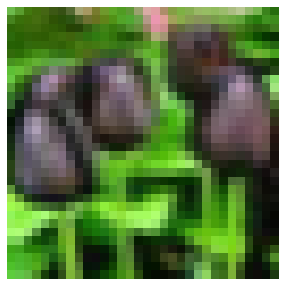

In [9]:
idx=0
if LOAD_IMG== "dataloader":
    if TESTING=='downstream':
        aug_params = augmentation_parameters(config)
        train_dataset = TartanAirEasy(config = config, aug_params = aug_params, split='train')
        val_dataset = TartanAirEasy(config = config, aug_params = aug_params, split='val')
        
        # left_image, right_image = dataset[i]
        sample = train_dataset[idx]
        _, left_img, right_img, disp, valid = sample

        left_image= ToArray(left_img)
        right_image= ToArray(right_img)
        disp_map = ToArray(disp)
        valid_map = ToArray(valid.unsqueeze(0))

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
        fig.suptitle('Downstream Stereo Images')
        ax1.imshow(left_image)
        ax2.imshow(right_image)
        ax3.imshow(disp_map, cmap='jet')
        ax4.imshow(valid_map)
        plt.show()
        
    else:
        train_dataset = SceneFlowLoader(config, 'train', train_transforms)
        val_dataset = SceneFlowLoader(config, 'val', train_transforms)
        sample = val_dataset[idx]
        left_img, right_img = sample['left_image'], sample['right_image']

        left_image= ToArray(left_img)
        right_image= ToArray(right_img)

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('MIM Stereo Images')
        ax1.imshow(left_image)
        ax1.axis('off')
        ax2.imshow(right_image)
        ax2.axis('off')
        plt.show()

else:
    img_path_left = ""
    # "/data/middlebury/testH/Bicycle2/im0.png"
    #"/data/middlebury/testF/Classroom2/im0.png"
    img_path_right= ""
    # "/data/middlebury/testH/Bicycle2/im1.png"
    #"/data/middlebury/testF/Classroom2/im1.png"

    # pre-process;
    left_img = Image.open(img_path_left).convert('RGB')
    left_img = left_img.resize((448,224))

    right_img = Image.open(img_path_right).convert('RGB')
    right_img = right_img.resize((448,224))

    assert np.shape(left_img) == (224, 448, 3)
    assert np.shape(right_img) == (224, 448, 3)

    # normalize by ImageNet mean and std
    #img = img - imagenet_mean
    #img = img / imagenet_std
    totensor = transforms.ToTensor()

    plt.rcParams['figure.figsize'] = [5, 5]
    show_image(totensor(left_img).permute(1,2,0), 'left image')
    show_image(totensor(right_img).permute(1,2,0), 'right image')

## Run the model for reconstruction

LV MAE vit with pixel reconstruction:


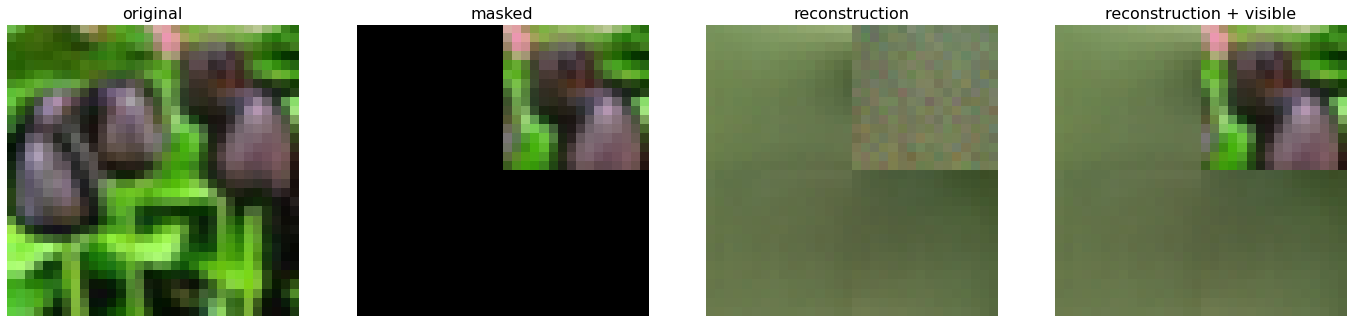

In [10]:

if LOAD_IMG== "dataloader":
    flow_predictions = run_one_image(left_img, right_img, model)
    show_flow(left_img, flow_predictions)
    
else:
    totensor = transforms.ToTensor()
    torch.manual_seed(2) # <<< random seed for random masking.
    left_img_t = totensor(left_img)
    right_img_t = totensor(right_img)
    flow_predictions = run_one_image(left_img_t, right_img_t, model)

    show_flow(left_img_t, flow_predictions)
    